This notebook gives simple examples on how to read and visualize the data provided for the challenge. For information on the data, see the Read Me.

In [37]:
# Importing the required libraries
import cartopy.crs as ccrs
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import os
import rasterio
import pandas as pd

In [65]:
satno2.shape

(1, 241, 162)

In [185]:
def read_raster_data(file_path):
    with rasterio.open(file_path) as src:
        raster_data = src.read(1)  

        transform = src.transform
        bounds = src.bounds
        
    return raster_data, transform, bounds

def extract_data_for_location(raster_data, transform, bounds, lon, lat):
    col, row = rasterio.transform.rowcol(transform, lon, lat)

    row = np.clip(row, 0, raster_data.shape[0] - 1)
    col = np.clip(col, 0, raster_data.shape[1] - 1)

    # Extract data at the specified location
    value = raster_data[row, col]

    return value

# Function to create DataFrame for a specific date
def create_dataframe_for_date(date, power_plants):
    data_list = []

    no2_file_path = f"satellite/NO2/no2_kgm2_{date}.tiff"
    cloud_fraction_file_path = f"satellite/cloud_fraction/cloud_fraction_{date}.tiff"
    uwind_file_path = f"weather/wind/uwind_ms_{date}.tiff"
    vwind_file_path = f"weather/wind/vwind_ms_{date}.tiff"
    temp_file_path = f"weather/temperature/temp_K_{date}.tiff"
    solar_radiation_file_path = f"weather/solar_radiation/solarrad_Wm2_{date}.tiff"
    humidity_path = f"weather/relative_humidity/RH_perc_{date}.tiff"
    bound_layer_path = f"weather/boundary_layer_height/BLH_m_{date}.tiff"
    no2flux_layer_path = f"NO2flux/no2flux_kgm2s_{date}.tiff"


    no2_data, no2_transform, no2_bounds = read_raster_data(no2_file_path)
    cloud_fraction_data, cloud_fraction_transform, cloud_fraction_bounds = read_raster_data(cloud_fraction_file_path)
    wind_data, wind_transform, wind_bounds = read_raster_data(uwind_file_path)
    vwind_data, vwind_transform, vwind_bounds = read_raster_data(vwind_file_path)
    temp_data, temp_transform, temp_bounds = read_raster_data(temp_file_path)
    solar_radiation_data,  solar_radiation_transform, solar_radiation_bounds = read_raster_data(solar_radiation_file_path)
    humidity_data, humidity_transform, humidity_bounds = read_raster_data(humidity_path)
    bound_layer_data, bound_layer_transform, bound_layer_bounds = read_raster_data(bound_layer_path)
    no2flux_data, no2flux_transform, no2flux_bounds = read_raster_data(no2flux_layer_path)


    for plant_id, plant_info in power_plants.iterrows():
        lon, lat = plant_info["longitude"], plant_info["latitude"]

        no2_value = extract_data_for_location(no2_data, no2_transform, no2_bounds, lon, lat)
        cloud_fraction_value = extract_data_for_location(cloud_fraction_data, cloud_fraction_transform, cloud_fraction_bounds, lon, lat)
        wind_value = extract_data_for_location(wind_data, wind_transform, wind_bounds, lon, lat)
        vwind_value = extract_data_for_location(vwind_data, vwind_transform, vwind_bounds, lon, lat)
        temp_value = extract_data_for_location( temp_data, temp_transform, temp_bounds, lon, lat)
        solar_radiation_value = extract_data_for_location(solar_radiation_data,  solar_radiation_transform, solar_radiation_bounds, lon, lat)
        humidity_value = extract_data_for_location(humidity_data, humidity_transform, humidity_bounds, lon, lat)
        boundlayer_value = extract_data_for_location(bound_layer_data, bound_layer_transform, bound_layer_bounds, lon, lat)
        no2flux_value = extract_data_for_location(no2flux_data, no2flux_transform, no2flux_bounds, lon, lat)

        data_list.append([date, plant_info["facility_id"], no2_value, cloud_fraction_value,wind_value,vwind_value,temp_value,solar_radiation_value,humidity_value,boundlayer_value,no2flux_value])

    result_df = pd.DataFrame(data_list, columns=["Date", "PowerPlantID", "NO2", "CloudFraction","UWind","VWind","Temp","SolarRadiation","Humidity","BoundLayer","No2flux"])

    return result_df

In [186]:
# Specify the date range
import numpy as np
start_date = "20190301"
end_date = "20230930"

# Create DataFrame for each date in the range
dfs = []
for single_date in pd.date_range(start_date, end_date):
    try:
        date_str = single_date.strftime("%Y%m%d")
        df_for_date = create_dataframe_for_date(date_str, power_plants)
        dfs.append(df_for_date)
    except:
        continue
# Concatenate all DataFrames
final_df = pd.concat(dfs, ignore_index=True)

In [187]:
final_df['wind_speed'] = final_df.apply(lambda row: np.sqrt(row['UWind']**2 + row['VWind']**2), axis=1)

In [188]:
# Define a function to calculate wind direction for a single row
import metpy.calc as mpcalc
from metpy.units import units

def calculate_wind_direction(row):
    u = row['UWind'] * units('m/s')
    v = row['VWind'] * units('m/s')
    return mpcalc.wind_direction(u, v).to(units.deg).magnitude

# Apply the function row by row to create a new column 'wind_direction'
final_df['wind_direction'] = final_df.apply(calculate_wind_direction, axis=1)

In [189]:
final_df.head()

,Date,PowerPlantID,NO2,CloudFraction,UWind,VWind,Temp,SolarRadiation,Humidity,BoundLayer,No2flux,wind_speed,wind_direction
0,20190301,S3200688,NaN,0.310145,-5121,7635,6872,-5866,76.814636,3086,NaN,9193.359886,146.14917905702848
1,20190301,F1700736,NaN,0.190310,10027,-6046,18420,21629,67.352455,-9444,NaN,11708.750787,301.0887994860034
2,20190301,H4810851,0.000001,0.115601,17288,2554,16984,22009,61.711430,-1822,NaN,17475.636183,261.59633405406913
3,20190301,C1400170,NaN,0.382771,27743,11231,16751,24679,57.774822,1463,NaN,29930.075342,247.9607733538215
4,20190301,E5400878,NaN,0.395512,-5151,8181,7724,-6592,77.233856,2357,NaN,9667.552017,147.80426606528675


In [190]:
final_df.shape

(18183, 13)

In [191]:
nox = pd.read_csv('Taiwan_nox_emissions.csv')
nox.shape

(15500, 6)

In [230]:
data['Date'] = pd.to_datetime(data['Date']).dt.strftime('%Y-%m-%d')

/tmp/ipykernel_1689182/4053970779.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date']).dt.strftime('%Y-%m-%d')


In [198]:
nox.head()

,facility_id,datetime,value,data_source,poll,unit,date
0,C1400170,2019-03-01,2833.708452,tw_epa,nox,kg,20190301
1,C1400170,2019-03-02,2838.442698,tw_epa,nox,kg,20190302
2,C1400170,2019-03-03,3248.871142,tw_epa,nox,kg,20190303
3,C1400170,2019-03-04,7802.961915,tw_epa,nox,kg,20190304
4,C1400170,2019-03-05,8781.186092,tw_epa,nox,kg,20190305


In [194]:
df = pd.merge(final_df, nox[['date','value','facility_id']], left_on=['Date', 'PowerPlantID'],right_on = ['date', 'facility_id'])

In [195]:
df = df.drop(columns = ['facility_id','date'])

In [196]:
df.head()

,Date,PowerPlantID,NO2,CloudFraction,UWind,VWind,Temp,SolarRadiation,Humidity,BoundLayer,No2flux,wind_speed,wind_direction,value
0,20190301,S3200688,NaN,0.310145,-5121,7635,6872,-5866,76.814636,3086,NaN,9193.359886,146.14917905702848,7998.471162
1,20190301,F1700736,NaN,0.190310,10027,-6046,18420,21629,67.352455,-9444,NaN,11708.750787,301.0887994860034,1380.525840
2,20190301,H4810851,0.000001,0.115601,17288,2554,16984,22009,61.711430,-1822,NaN,17475.636183,261.59633405406913,1338.327590
3,20190301,C1400170,NaN,0.382771,27743,11231,16751,24679,57.774822,1463,NaN,29930.075342,247.9607733538215,2833.708452
4,20190301,E5400878,NaN,0.395512,-5151,8181,7724,-6592,77.233856,2357,NaN,9667.552017,147.80426606528675,1424.449099


In [197]:
data = df.dropna(subset=['NO2'])

In [278]:
X = data.drop(columns = ['Date','PowerPlantID','value','wind_direction','wind_speed','No2flux','date'])
y = data['value']

In [279]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [280]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import numpy as np
import pandas as pd

# Assuming X_train, X_test, y_train, and y_test are your training and testing data
# Also assuming feature_imp is a DataFrame with feature importances

xgb_reg = xgb.XGBRegressor()

xgb_reg.fit(X_train, np.ravel(y_train))

y_pred = xgb_reg.predict(X_test)

# Evaluate on root mean squared error (RMSE)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Evaluate on R-squared (R2)
test_r2 = r2_score(y_test, y_pred)


In [281]:
print('Root Mean Squared Error on test set:', test_rmse)
print('R-squared on test set:', test_r2)

Root Mean Squared Error on test set: 4108.861598613729
R-squared on test set: 0.2611411313990962


In [282]:
# Combine predictions and actual values into a DataFrame
result_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'PowerPlantID': data.loc[X_test.index,'PowerPlantID'],'Date': data.loc[X_test.index,'Date']})

# Calculate RMSE and R-squared at the plant level for each date
plant_date_level_metrics = result_df.groupby(['Date', 'PowerPlantID']).apply(lambda group: pd.Series({
    'RMSE': np.sqrt(mean_squared_error(group['Actual'], group['Predicted'])),
    'R2': r2_score(group['Actual'], group['Predicted'])
})).reset_index()

# Predict emissions for each plant and date
# Assuming emission feature is 'emission_feature'
emission_predictions = result_df.groupby(['Date', 'PowerPlantID'])['Predicted'].mean().reset_index()

/home/aisyah/hacktotherescue/my-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/aisyah/hacktotherescue/my-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/aisyah/hacktotherescue/my-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/aisyah/hacktotherescue/my-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/aisyah/hacktotherescue/my-env/lib/python3.9/site-packages/sklearn/metrics/_regression.

In [283]:
plant_date_level_metrics.head(10)

,Date,PowerPlantID,RMSE,R2
0,2019-03-02,L0200473,7266.638472,NaN
1,2019-03-05,H5307960,909.574753,NaN
2,2019-03-09,K7000764,5211.967156,NaN
3,2019-03-10,S3200688,1492.357226,NaN
4,2019-03-12,L0200473,13536.215205,NaN
5,2019-03-14,E5400878,3637.404842,NaN
6,2019-03-14,E5600896,1401.045003,NaN
7,2019-03-14,L0200473,10521.816151,NaN
8,2019-03-16,S3200688,6224.268400,NaN
9,2019-03-18,S3200688,4168.662342,NaN


In [247]:
# Combine predictions and actual values into a DataFrame
result_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'PowerPlantID': data.loc[X_test.index,'PowerPlantID'],'Date': data.loc[X_test.index,'Date']})
result_df = pd.concat([result_df, X_test], axis=1)

# Calculate RMSE and R-squared at the plant level
plant_level_metrics = result_df.groupby('PowerPlantID').apply(lambda group: pd.Series({
    'RMSE': np.sqrt(mean_squared_error(group['Actual'], group['Predicted'])),
    'R2': r2_score(group['Actual'], group['Predicted'])
})).reset_index()

# Predict emissions for each plant
# Assuming emission feature is 'emission_feature'
emission_predictions = result_df.groupby('PowerPlantID')['Predicted'].mean().reset_index()

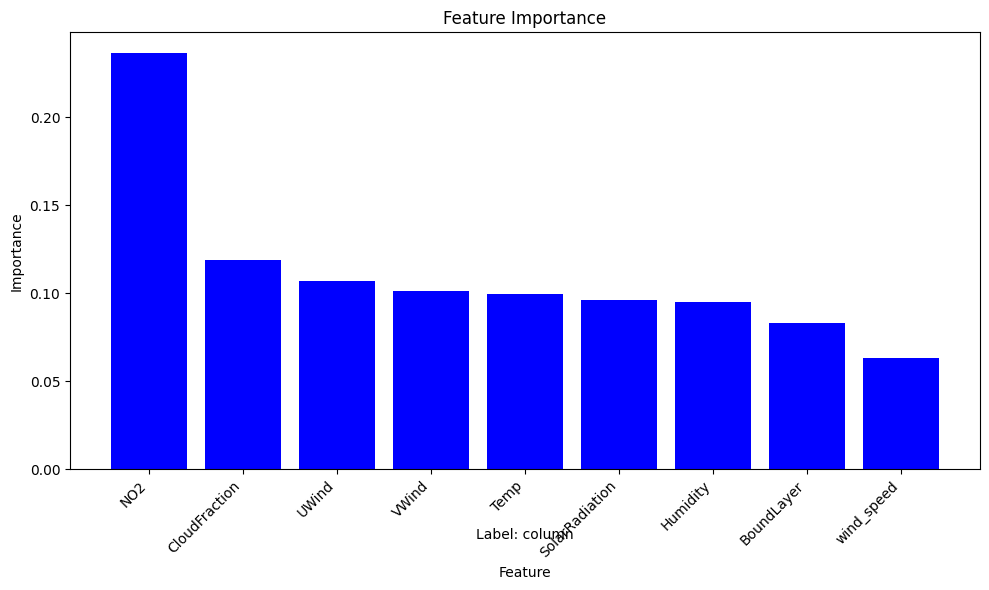

In [156]:
import matplotlib.pyplot as plt

# Assuming 'label' is the column name for your target variable in your feature_imp DataFrame
label = 'column'

# Sort feature importance values in descending order
feature_imp = feature_imp.sort_values(by='importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(X.columns, feature_imp['importance'], color='blue')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Add the label to the plot
plt.text(0.5, -0.15, f'Label: {label}', transform=plt.gca().transAxes, fontsize=10, va='center', ha='center')
plt.show()

In [284]:
import pickle

with open("model.pkl", "wb") as f:
    pickle.dump(xgb_reg, f)

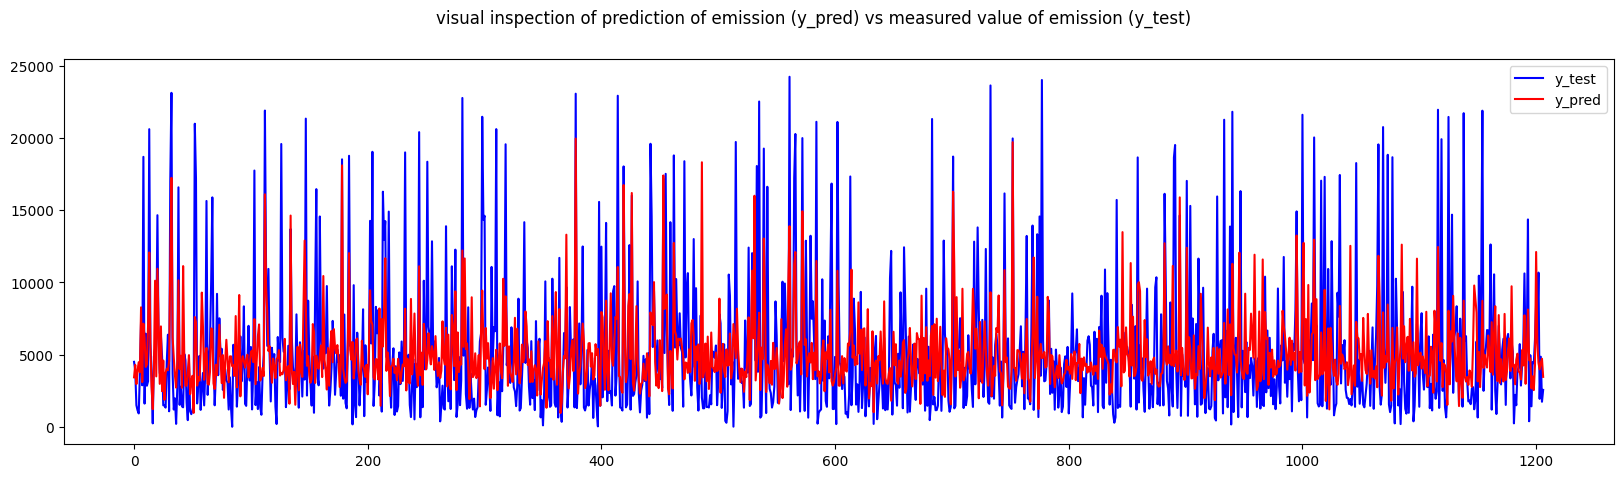

In [184]:
fig12 = plt.figure(figsize=(20, 5))
fig12.suptitle("visual inspection of prediction of emission (y_pred) vs measured value of emission (y_test)")
ax1 = fig12.add_subplot(111)
ax1.plot(range(0,len(y_test)), y_test, label='y_test', color='b')
#ax12 = ax1.twinx()
ax1.plot(range(0,len(y_test)), y_pred, label='y_pred', color='r') 
ax1.legend(); #; ax12.legend()

- R2- 
root-mean-square-error (RMSE
